In [1]:
import torch
import numpy as np
from matplotlib import pyplot as plt
import yfinance as yf

/Users/maximeszymanski/PycharmProjects/StocksClusteringVAE/venv/lib/python3.9/site-packages/urllib3/__init__.py:34: NotOpenSSLWarning: urllib3 v2.0 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


[*********************100%%**********************]  1 of 1 completed
shape before : (1006,)
shape after : (1000,)


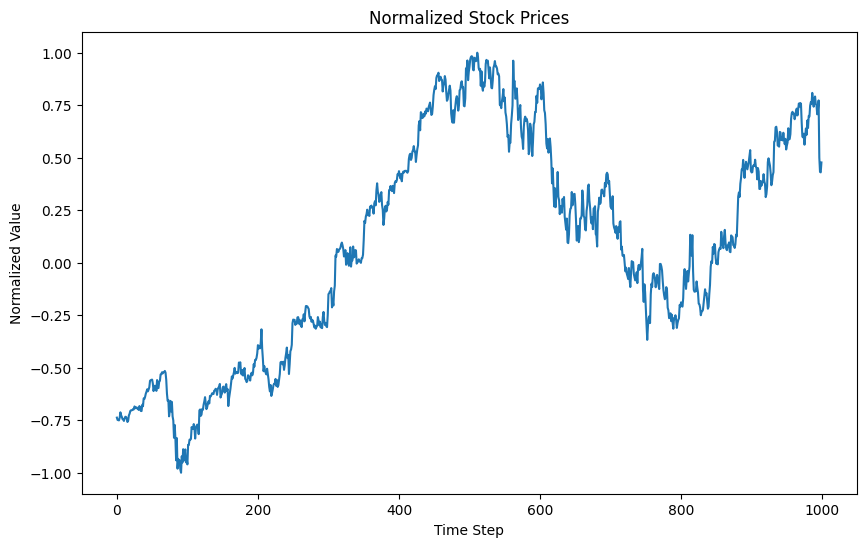

In [2]:

# Define the stock symbol (Google in this case)
stock_symbol = 'GOOGL'

# Define the date range for the past 4 years
start_date = '2019-11-08'
end_date = '2023-11-08'

# Download historical stock data using yfinance
stock_data = yf.download(stock_symbol, start=start_date, end=end_date)

# Extract the 'Close' column
close_values = stock_data['Close'].values

# Normalize the data between -1 and 1
normalized_values = 2 * (close_values - np.min(close_values)) / np.ptp(close_values) - 1
print(f"shape before : {normalized_values.shape}")
# remove the last 6 values
normalized_values = normalized_values[:-6]
print(f"shape after : {normalized_values.shape}")
# Plot the normalized data
plt.figure(figsize=(10, 6))
plt.plot(normalized_values)
plt.title('Normalized Stock Prices')
plt.xlabel('Time Step')
plt.ylabel('Normalized Value')
plt.show()

In [3]:
sub_series_length = 50
assert len(normalized_values) % sub_series_length == 0
sub_series = normalized_values.reshape((-1, sub_series_length))
print(f"sub_series shape : {sub_series.shape}")


sub_series shape : (20, 50)


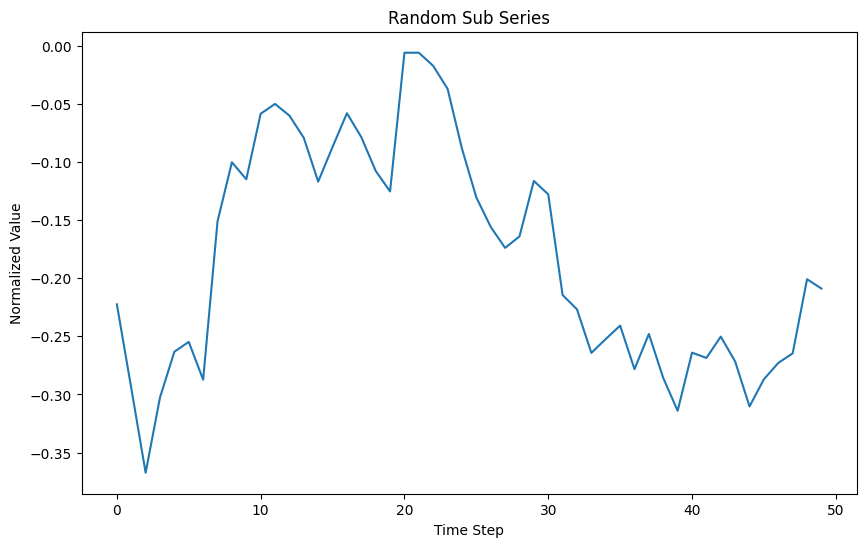

In [4]:
# print a random sub series
random_index = np.random.randint(0, sub_series.shape[0])
plt.figure(figsize=(10, 6))
plt.plot(sub_series[random_index])
plt.title('Random Sub Series')
plt.xlabel('Time Step')
plt.ylabel('Normalized Value')
plt.show()


In [47]:
import torch
import torch.nn as nn
import torch.nn.functional as F
class Encoder(nn.Module):
  def __init__(self, seq_len, n_features, embedding_dim=64,num_layers=3,bidirectional=False,
               transfromer_hidden_size_attention = 64,num_heads=8,sub_seq_len=10):
    super(Encoder, self).__init__()
    assert seq_len % sub_seq_len  == 0
    self.number_of_sub_seq = seq_len // sub_seq_len
    self.sub_seq_len = sub_seq_len
    self.seq_len, self.n_features = seq_len, n_features
    self.embedding_dim, self.hidden_dim = embedding_dim, 2 * embedding_dim
    print(f"hidden_dim: {self.hidden_dim}")
    self.num_layers = num_layers
    self.bidirectional = bidirectional
    self.rnn1 = nn.LSTM(
          input_size=n_features,
          hidden_size=self.hidden_dim,
          num_layers=self.num_layers,
          batch_first=True,
            bidirectional=self.bidirectional
        )


    multiple_bi = 2 if bidirectional else 1

    self.rnn2 = nn.LSTM(
          input_size=multiple_bi * self.hidden_dim,
          hidden_size=embedding_dim,
          num_layers=self.num_layers,
          batch_first=True
    )

    self.transformer = TransformerLSTMBlock(input_size=embedding_dim,output_size=embedding_dim,
                                            hidden_size_attention=transfromer_hidden_size_attention,
                                            sequence_len=self.sub_seq_len,num_heads=num_heads)

  def forward(self, x):
    print(f"encoder input shape : {x.shape}")
    batch_size, seq_len, n_features = x.size()
    #x = x.reshape((batch_size * seq_len, n_features))
    x, (_, _) = self.rnn1(x)
    x, (hidden_n, _) = self.rnn2(x)
    x = x.reshape((batch_size * self.number_of_sub_seq, self.sub_seq_len, self.embedding_dim))
    x = self.transformer(x)
    x = x.reshape((batch_size, self.seq_len, self.embedding_dim))
    print(f"encoder output shape : {x.shape}")

    return hidden_n



class Decoder(nn.Module):
  def __init__(self, seq_len, input_dim=64, n_features=1,num_layers=3,bidirectional=False):
    super(Decoder, self).__init__()
    self.seq_len, self.input_dim = seq_len, input_dim
    self.hidden_dim, self.n_features = 2 * input_dim, n_features
    self.num_layers = num_layers
    self.bidirectional = bidirectional
    self.rnn1 = nn.LSTM(
          input_size=input_dim,
          hidden_size=input_dim,
          num_layers=self.num_layers,
          batch_first=True,
            bidirectional=self.bidirectional
        )

    multiple_bi = 2 if bidirectional else 1
    self.rnn2 = nn.LSTM(
      input_size=input_dim * multiple_bi,
      hidden_size=self.hidden_dim,
      num_layers=self.num_layers,
      batch_first=True
    )
    self.output_layer = nn.Linear(self.hidden_dim, n_features)
  def forward(self, x):


    batch_size = x.size(0)
    # x is shape (batch_size, 1, n_features)
    # repeat the last dimension to have (batch_size, seq_len, n_features)
    x = x.repeat(1, self.seq_len, 1)
    x, (hidden_n, cell_n) = self.rnn1(x)
    x, (hidden_n, cell_n) = self.rnn2(x)
    x = x.reshape((batch_size,self.seq_len, self.hidden_dim))
    # keep only the last layer


    return self.output_layer(x)

class AttentionLSTMBlock(nn.Module):
    def __init__(self, input_size, output_size, hidden_size_attetion,sequence_len):
        super(AttentionLSTMBlock, self).__init__()
        self.input_size = input_size
        self.output_size = output_size
        self.hidden_size = hidden_size_attetion
        self.sub_seq_len = sequence_len
        self.Q = nn.Linear(self.input_size, self.hidden_size)
        self.K = nn.Linear(self.input_size, self.hidden_size)
        self.V = nn.Linear(self.input_size, self.hidden_size)


    def forward(self, x):
        # x is shape (batch_size, sub_seq_len, n_features)
        # repeat the last dimension to have (batch_size, seq_len, n_features)

        Q = self.Q(x)
        K = self.K(x)
        V = self.V(x)
        # Q, K, V are shape (batch_size, seq_len, hidden_size)
        # compute the attention weights
        attention_weights = torch.bmm(Q, K.transpose(1, 2))

        attention_weights = F.softmax(attention_weights, dim=2)
        # attention_weights shape is (batch_size, seq_len, seq_len)
        # compute the output
        out = torch.bmm(attention_weights, V)
        # out shape is (batch_size, seq_len, hidden_size)
        return out
class MultiHeadAttentionLSTMBlock(nn.Module):
    def __init__(self, input_size, output_size, hidden_size_attention, sequence_len, num_heads):
        super(MultiHeadAttentionLSTMBlock, self).__init__()
        self.input_size = input_size
        self.output_size = output_size
        self.hidden_size = hidden_size_attention
        self.sub_seq_len = sequence_len
        self.num_heads = num_heads

        # Linear projections for each head
        self.Q_linear = nn.Linear(self.input_size, self.hidden_size * self.num_heads)
        self.K_linear = nn.Linear(self.input_size, self.hidden_size * self.num_heads)
        self.V_linear = nn.Linear(self.input_size, self.hidden_size * self.num_heads)

        # Final linear transformation
        self.output_linear = nn.Linear(self.hidden_size * self.num_heads, self.output_size)

    def forward(self, x):
        # x is shape (batch_size, sub_seq_len, n_features)

        # Linear projections for each head
        Q = self.Q_linear(x).view(-1, self.sub_seq_len, self.num_heads, self.hidden_size)
        K = self.K_linear(x).view(-1, self.sub_seq_len, self.num_heads, self.hidden_size)
        V = self.V_linear(x).view(-1, self.sub_seq_len, self.num_heads, self.hidden_size)

        # Transpose to get dimensions (batch_size, num_heads, seq_len, hidden_size)
        Q = Q.transpose(1, 2)
        K = K.transpose(1, 2)
        V = V.transpose(1, 2)

        # Compute attention weights
        attention_weights = torch.matmul(Q, K.transpose(2, 3)) / (self.hidden_size ** 0.5)

        attention_weights = F.softmax(attention_weights, dim=-1)

        # Apply attention weights to values
        out = torch.matmul(attention_weights, V)

        # Transpose back to (batch_size, seq_len, num_heads, hidden_size)
        out = out.transpose(1, 2)

        # Concatenate along the last dimension
        out = out.contiguous().view(-1, self.sub_seq_len, self.num_heads * self.hidden_size)

        # Final linear transformation
        out = self.output_linear(out)

        return out

class TransformerLSTMBlock(nn.Module):
    def __init__(self, input_size, output_size, hidden_size_attention, sequence_len, num_heads):
        super(TransformerLSTMBlock, self).__init__()
        self.input_size = input_size
        self.output_size = output_size
        self.hidden_size = hidden_size_attention
        self.sub_seq_len = sequence_len
        self.num_heads = num_heads

        self.multi_head_attention = MultiHeadAttentionLSTMBlock(self.input_size, self.output_size, self.hidden_size, self.sub_seq_len, self.num_heads)
        self.layer_norm1 = nn.LayerNorm(self.output_size)
        self.layer_norm2 = nn.LayerNorm(self.output_size)
        self.feed_forward = nn.Linear(self.output_size, self.output_size)

    def forward(self, x):
        # x is shape (batch_size, sub_seq_len, n_features)
        # compute the attention
        attention = self.multi_head_attention(x)
        # add the residual connection
        x = x + attention
        # normalize
        x = self.layer_norm1(x)
        # feed forward
        feed_forward = self.feed_forward(x)
        # add the residual connection
        x = x + feed_forward
        # normalize
        x = self.layer_norm2(x)
        return x

#generate random data shape (10,40,1)
x = torch.rand(10,40,1)
atention = TransformerLSTMBlock(1,7,64,40,5)
atention(x).shape

torch.Size([10, 40, 7])

In [48]:
class RecurrentAutoencoder(nn.Module):
  def __init__(self, seq_len, n_features, embedding_dim=64):
    super(RecurrentAutoencoder, self).__init__()
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    self.encoder = Encoder(seq_len, n_features, embedding_dim,bidirectional=True,num_layers=1).to(device)
    self.decoder = Decoder(seq_len, embedding_dim, n_features,bidirectional=True,num_layers=1).to(device)
  def forward(self, x):
    x = self.encoder(x)
    x = self.decoder(x)
    x = nn.Tanh()(x)
    return x

In [49]:
model = RecurrentAutoencoder(sub_series_length, 1, 64)
print(f"model : {model}")

hidden_dim: 128
model : RecurrentAutoencoder(
  (encoder): Encoder(
    (rnn1): LSTM(1, 128, batch_first=True, bidirectional=True)
    (rnn2): LSTM(256, 64, batch_first=True)
    (transformer): TransformerLSTMBlock(
      (multi_head_attention): MultiHeadAttentionLSTMBlock(
        (Q_linear): Linear(in_features=64, out_features=512, bias=True)
        (K_linear): Linear(in_features=64, out_features=512, bias=True)
        (V_linear): Linear(in_features=64, out_features=512, bias=True)
        (output_linear): Linear(in_features=512, out_features=64, bias=True)
      )
      (layer_norm1): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
      (layer_norm2): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
      (feed_forward): Linear(in_features=64, out_features=64, bias=True)
    )
  )
  (decoder): Decoder(
    (rnn1): LSTM(64, 64, batch_first=True, bidirectional=True)
    (rnn2): LSTM(128, 128, batch_first=True)
    (output_layer): Linear(in_features=128, out_features=1, bia

In [50]:
# try with sinusoidal signal
latent_dim = 1
# take only square and sinusoidal signals


signal_to_tensor = torch.from_numpy(sub_series).float().unsqueeze(2)

output = model(signal_to_tensor)
print(f"Input shape: {signal_to_tensor.shape}")
print(f"Output shape: {output.shape}")

encoder input shape : torch.Size([20, 50, 1])
encoder output shape : torch.Size([100, 10, 64])


RuntimeError: shape '[1, 50, 128]' is invalid for input of size 128000

(50,)


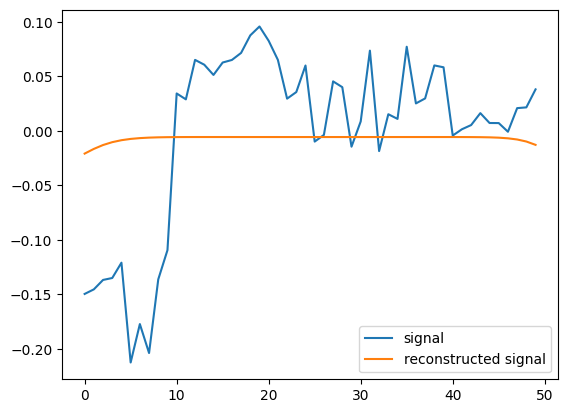

In [19]:
# plot the reconstruction
# get a random signal
random_index = np.random.randint(0, sub_series.shape[0])
output_decoded = output[random_index].squeeze().detach().numpy()
# take the first signal
signal = signal_to_tensor[random_index].squeeze().detach().numpy()
print(signal.shape)
plt.plot(signal, label='signal')
plt.plot(output_decoded, label='reconstructed signal')
plt.legend()
plt.show()


In [23]:
# try a simple overfitting
optimizer = torch.optim.Adam(model.parameters(), lr=0.00008)
#loss_fn = nn.L1Loss(reduction='sum')
loss_fn = nn.MSELoss(reduction='sum')
for epoch in range(1000):
    optimizer.zero_grad()
    print(f"signal_to_tensor[0]: {signal_to_tensor[0]}")
    output = model(signal_to_tensor)

    loss = loss_fn(output, signal_to_tensor)
    loss.backward()
    # visualize the gradients of the last lstm layer

    optimizer.step()
    if epoch % 10 == 0:
        print(f'Epoch: {epoch}, loss: {loss.item()}')

signal_to_tensor[0]: tensor([[-0.7376],
        [-0.7486],
        [-0.7497],
        [-0.7508],
        [-0.7375],
        [-0.7123],
        [-0.7264],
        [-0.7339],
        [-0.7450],
        [-0.7467],
        [-0.7534],
        [-0.7411],
        [-0.7335],
        [-0.7344],
        [-0.7427],
        [-0.7583],
        [-0.7523],
        [-0.7274],
        [-0.7191],
        [-0.7063],
        [-0.7026],
        [-0.7027],
        [-0.7013],
        [-0.6969],
        [-0.6986],
        [-0.6844],
        [-0.6904],
        [-0.6934],
        [-0.6888],
        [-0.6941],
        [-0.6947],
        [-0.7011],
        [-0.6826],
        [-0.6906],
        [-0.7060],
        [-0.7063],
        [-0.6762],
        [-0.6835],
        [-0.6462],
        [-0.6490],
        [-0.6387],
        [-0.6235],
        [-0.6141],
        [-0.6027],
        [-0.6124],
        [-0.6036],
        [-0.5923],
        [-0.5620],
        [-0.5592],
        [-0.5576]])
Epoch: 0, loss: 6.6381316184

KeyboardInterrupt: 

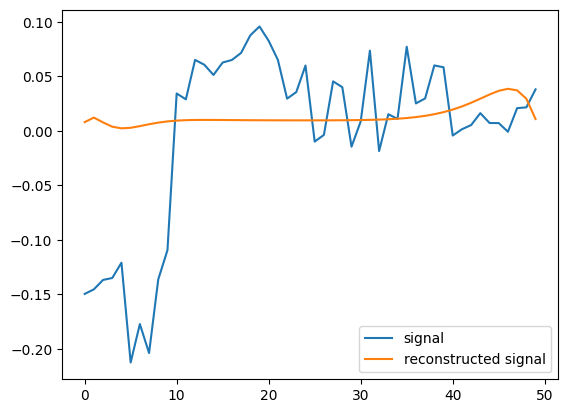

In [21]:
# plot the reconstruction
# get a random signal
random_index = np.random.randint(0, sub_series.shape[0])
output_decoded = output[random_index].squeeze().detach().numpy()
# take the first signal
signal = signal_to_tensor[random_index].squeeze().detach().numpy()
plt.plot(signal, label='signal')
plt.plot(output_decoded, label='reconstructed signal')
plt.legend()
plt.show()


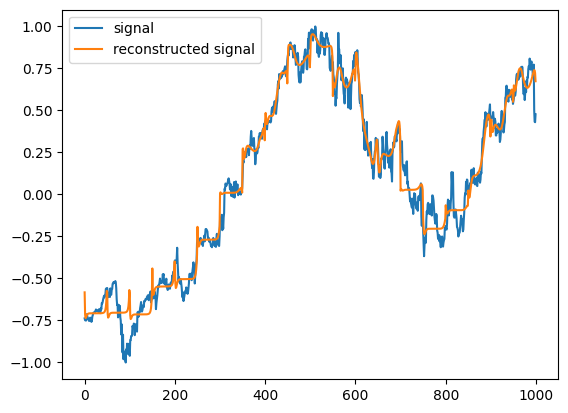

In [22]:
# encode and decode all the signals
singals = model(signal_to_tensor).squeeze().detach().numpy()
# concatenate all the signals

signals = singals.reshape(len(normalized_values))
# plot
plt.plot(normalized_values, label='signal')
plt.plot(signals, label='reconstructed signal')
plt.legend()
plt.show()
